# **Un peu d'Exploratory Data Analysis avant toutes choses**

Ce notebook vise à explorer rapidement la base de données pour avoir une idée de se composition, la répartition et éventuels déséquilibres entre les classes, les caractéristiques des textes à analyser. Cela est éventuellement l'occasion de détecter des particularismes dans les messages qu'il faudra bien prendre en compte dans le preprocessing. Les principales conclusions sont :
- Labels overlapping mais équilibrés dans l'échantillon test
- Attention à l'encodage _diacritique_ des accents qui ne correspond pas à celui "du clavier azerty" (exemple : é dans le jeu de données est égale à e (U+0065)

# 1. Packages usuels et importation de la base train

In [1]:
# Pour faciliter la mise à jour des fonctions écrites dans func_custom sans avoir à redémarrer le kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Packages classiques
import pandas as pd

# Custom package
import func_custom as fc

# NLP
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Les messages étant longs, cela permettra de visualiser un peu plus de contenu directement depuis le notebook
pd.set_option('max_colwidth', 300)

La variable `Unnamed: 0` semble juste être un indice de ligne, on peut pour le moment ne pas le garder pour l'analyse. Gardons l'encodage par défaut de `pd.read_excel` et nous étudierons cela plus tard dans le notebook.

In [4]:
df = pd.read_excel("data/data_train.xlsx",
                    usecols = ["label", "message"])

# 2. Rapides statistiques descriptives : dataframe et `label`

In [5]:
df.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    700 non-null    object
 1   message  700 non-null    object
dtypes: object(2)
memory usage: 1.0 MB


Il n'y a _a priori_ pas de valeurs nulles dans l'échantillon, vérifions le case suivante.

In [6]:
df.isna().sum()

label      0
message    0
dtype: int64

In [8]:
df.sample(3)

,label,message
418,1:8,"modification du taux d'appel messieurs, je vous fais part de mon souhait quant à la révision du taux d'appel de mon imposition.que j'ai choisi séparé de mon épouse soit 0000.0000%. en effet mon activité d'apporteur d'affaires ne me garantie pas des encaissements d'honoraires constant voir ..."
250,8,"Bonjour, Ayant déclaré un Pacs pour 0000, nous faisons pour la première fois une déclaration commune. Il nous est demandé de renseigner les coordonnées bancaire pour le prélèvement à la source, avant de signer la déclaration. Or nous souhaiterions que nos impôts respectifs soient déb..."
605,1,"Bonjour, Les sommes prélevées mensuellement sur mes pensions de retraites régime générale et complémentaires ainsi que le salaire de ma femme apparaitront-elles tous les mois dans mon espace personnel "" mon compte"". Si c'est le cas ,les sommes prélevées ce 0000 janvier 0000 sur mes pensi..."


Regardons maintenant succinctement la distribution des labels

In [9]:
df["label"].value_counts()

8      309
1      302
1:8     89
Name: label, dtype: int64

On constate que l'échantillon est **équilibré entre les classes 1 et 8**, il n'y a pas de déséquilibres et donc les techniques de prises en charge d'_imbalanced dataset_ ne sont pas nécessaires :
- Upsampling/downsampling voire SMOTE pour augmentation synthétique
- Changement de la métrique à retenir

# 3. Exploration des `message`

Certes partie vise i) à identifier des premiers éléments à partir de l'étude brute du texte et ii) découvrir des éléments importants qu'il faudra tenir en compte dans le preprocessing

## 3.1 Métriques simples

In [10]:
# Générateur aléatoire de messages pour première inspection visuelle
df.sample(1)["message"].values[0]

"Bonjour, J'ai effectué ce jour, mon changement de situation, à savoir mon mariage intervenu courant 0000. Selon mes précédentes estimations faites sur votre site, ma part et celle de mon mari devrait être partagées à 0000,0000% d'impôt en prélèvement sur nos salaires respectifs, cependant votre site nous rend non imposable, c'est chose très peu probable. Merci de clarifier la situation afin que nous n'ayons pas de rattrapage. En vous remerciant, Nos meilleurs vœux ! XXXXX et XXXXX XXXXX"

In [11]:
# Quelques fonctions simples pour caractériser les messages, et comparer d'éventuelles différences entre les labels
df["len_message"] = df["message"].apply(len)
df["count_words"] = df["message"].apply(lambda x: fc.count_words(x))

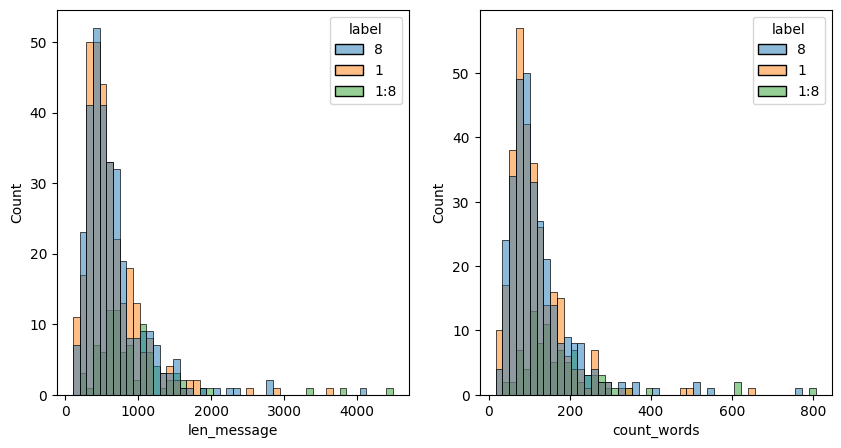

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

_ = sns.histplot(data = df,
                 ax = axes[0],
                 x = "len_message",
                 hue = "label")

_ = sns.histplot(data = df,
                 ax = axes[1],
                 x = "count_words",
                 hue = "label")

## 3.2 WordCloud (quasi) brut

In [17]:
# Concaténer tous les textes dans cette colonne en une seule chaîne de caractères
text = ' '.join(df["message"].dropna())

# Premier jeu standard de stopwords que l'on travaillera dans le notebook suivant
stopwords_french = set(stopwords.words('french'))

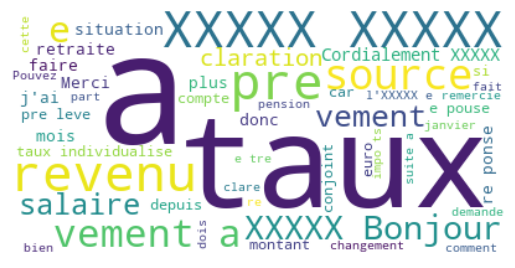

In [18]:
wordcloud = WordCloud(background_color = 'white',
                      stopwords =  stopwords_french,
                      max_words = 50).generate(text)

# Affichage du nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Sans surprise ce nuage de mot n'est pas très informatif. En plus des biais inhérent aux nuages de mots (mauvaise visualisation de l'information, biais vers les mots longs) on constate d'autres choses :
- Stopwork supplémentaires à prendre en compte (`XXXXX` issus de pseudonyamisation)
- Problème autour des accents qui scindent les mots : il faudra regarder pour la normalisation des mots avec accents

Il est déjà nécessaire de rentrer un peu plus dans le preprocessing pour prendre en compte ces spécificités et pouvoir en tirer plus d'informations, ainsi qu'être exploitable en vue du machine learning.

Tout ça à supprimer

### ----- Rapide analyse des mots, permet de détecter les étapes de preprocessing à implémenter

In [13]:
# df["impurity"] = df["message"].apply(fc.impurity, min_len = 10)

# df[df["impurity"] > 0.001].head()

In [18]:
# Concaténer tous les textes dans cette colonne en une seule chaîne de caractères
text = ' '.join(df["message"].dropna())

On va réaliser un très succinct preprocessing pour se débarasser de ponctuation et stopword issus de nltk, ceci à des fins de première analyse. Les étapes suivantes seront ensuite justifiées, améliorées et packagées dans `func_custom.py`

In [19]:
stopwords_french = set(stopwords.words('french'))

In [20]:
# Premières étapes de la future fonction de preprocessing
def preprocess_eda(text, stopwords):
    text = text.lower()
    text_punct = fc.replace_punctuation_with_space(text)
    tokens = word_tokenize(text_punct, language = "french")
    tokens_clean = [token for token in tokens if token not in stopwords]
    return tokens_clean


In [21]:
tokens_clean = preprocess_eda(text, stopwords_french)

In [22]:
pd.DataFrame(tokens_clean).value_counts().head(5)

0000       4705
à         2036
xxxxx      1776
taux       1323
revenus     710
dtype: int64

On constate que la simple inclusion des stopwords par défaut de nltk ne suffira pas, des éléments spécifiques au jeu de données (`xxxxx` et `0000` issus de pseudonymisation, `bonjour` et `merci` et mots de politesse du fait qu'il s'agit de message écrits par des particuliers à la DGFIP). On peut alors compléter de manière _ad hoc_ cette liste en regardant à l'oeil nu ces éléments. Si l'exerice consiste cependant à distinguer les messages "polis" des autres alors cette liste de stopwords n'est absolument pas pertinente.

TF-IDF aurait dans une certaine mesure pu tenir compte de ces mots largement présent dans le corpus et peu informatif, autant traiter ce problème à la racine ce qui limitera la taille des données à traiter par la suite.

In [23]:
stopwords_adhoc = {"0000", "à", "xxxxx", "bonjour", "a", "cordialement", "merci", "xxxxx́e", "0000€", "donc", "car", "cette", "cela",
                  "être", "si", "même", "faire", "avoir", "remercie", "madame", "monsieur"}
stopwords = stopwords_french.union(stopwords_adhoc)

In [24]:
tokens_clean = preprocess_eda(text, stopwords)

In [25]:
pd.DataFrame(tokens_clean).value_counts().head(10)

à               2036
taux             1323
revenus           710
prélèvement     670
source            526
plus              366
déclaration      300
comment           271
bien              256
situation         255
dtype: int64

De manière _a priori_ surprenante les `à` n'ont pas été filtrés, cela indique qu'il faudra réaliser une étape de normalisation des caractères avec accents notamment.

In [26]:
# Caractère issu du jeu de données
print("à".encode("unicode_escape"))

# Caractère clavier
print("à".encode("unicode_escape"))

b'a\\u0300'
b'\\xe0'


Si l'on regarde l'encodage dans le jeu de données (a\\u0300) et celui du clavier (\\xe0) on s'aperçoit que le jeu de données possède des caractères encodés de manière diacritiques.
Il faudra penser à uniformiser le jeu de données dans le preprocessing, par simplicité/sécurité nous allons choisir celui du clavier.

In [28]:
print([t.encode("unicode_escape") for t in test_encodage])
print([t.encode("unicode_escape") for t in keyboard_encodage])

[b'pre\\u0301le\\u0300vement', b'e\\u0301poux', b'a\\u0300', b'impo\\u0302ts']
[b'pr\\xe9l\\xe8vement', b'\\xe9poux', b'\\xe0', b'imp\\xf4ts']


On vérifie bien qu'après normalisation les deux correspondent. À noter qu'il est également possible d'avoir recours au package `textacy` pour traiter ce type de problèmes.

In [30]:
print([unicodedata.normalize("NFKC", t).encode("unicode_escape") for t in test_encodage])
print([unicodedata.normalize("NFKC", t).encode("unicode_escape") for t in keyboard_encodage])

[b'pr\\xe9l\\xe8vement', b'\\xe9poux', b'\\xe0', b'imp\\xf4ts']
[b'pr\\xe9l\\xe8vement', b'\\xe9poux', b'\\xe0', b'imp\\xf4ts']
